In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.features import preprocessing

2023-03-07 11:12:39.655723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 11:12:40.426164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:$LD_LIBRARY_PATH
2023-03-07 11:12:40.426251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:$LD_LIBRARY_PATH
2023-03-07 11:12:40.426302: W tensorflow/compiler/tf

In [15]:
# Bypass issues with invoking notebook with server arguments
sys.argv.clear()
sys.argv.append("")

In [16]:
%run utils/attention_graph.py
%run utils/mlflow_query.py
%run utils/loading.py
%run utils/comparison.py
%run utils/ranks.py

In [57]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), experiment_id="222398694951089913")
mlflow_helper.query_valid_runs(pkl_file=Path("mlflow_run_df.pkl"))

Initialized with 94 MLFlow runs from pkl


Querying data per run...: 0it [00:00, ?it/s]


Queried 94 runs from MLFlow for mimic


Querying data per run...:   0%|          | 0/96 [00:00<?, ?it/s]/home/i40/pacev/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/i40/pacev/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
Querying data per run...: 100%|██████████| 96/96 [00:00<00:00, 2787.90it/s]

Queried 96 runs from MLFlow for huawei_logs


In [5]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell",
                     "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,112
coarse_log_cluster_template_drain,attributes,simple,53
coarse_log_cluster_template_nulog,attributes,simple,50
coarse_log_cluster_template_spell,attributes,simple,34
fine_log_cluster_template_drain,attributes,simple,56
fine_log_cluster_template_nulog,attributes,simple,50
fine_log_cluster_template_spell,attributes,simple,36
medium_log_cluster_template_drain,attributes,simple,54
medium_log_cluster_template_nulog,attributes,simple,50


In [10]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template", "medium_log_cluster_template", ""],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=False,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,60
coarse_log_cluster_template,attributes,simple,30
fine_log_cluster_template,attributes,simple,33
medium_log_cluster_template,attributes,simple,31


In [6]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 529/529 [00:32<00:00, 16.53it/s]


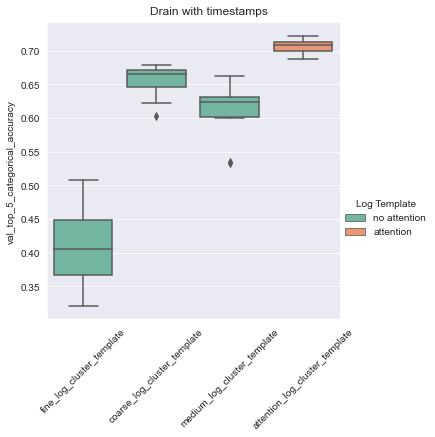

In [12]:

df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "False")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "drain")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "medium_log_cluster_template", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("with_timestamps.png", dpi=300, bbox_inches="tight")
plt.suptitle("Drain with timestamps")
plt.show()

In [41]:
df = pd.read_pickle("../all_logs.pkl")
df = df [["num_logs", "num_events", "all_events", "attributes", "fine_log_cluster_template_drain", "medium_log_cluster_template_drain", "coarse_log_cluster_template_drain", "fine_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "coarse_log_cluster_template_nulog"]]
df.to_pickle("../templates.pkl")
df.head()

,num_logs,num_events,all_events,attributes,fine_log_cluster_template_drain,medium_log_cluster_template_drain,coarse_log_cluster_template_drain,fine_log_cluster_template_nulog,medium_log_cluster_template_nulog,coarse_log_cluster_template_nulog
0,863,863,"[[Hostname#wally113, coarse_log_cluster_templa...","[[Hostname#wally113, , http_status#200.0, , pr...",[[fine_log_cluster_template_drain#get resource...,[[medium_log_cluster_template_drain#get resour...,[[coarse_log_cluster_template_drain#get resour...,"[[fine_log_cluster_template_nulog#- - - ""get ...","[[medium_log_cluster_template_nulog#- - - ""ge...","[[coarse_log_cluster_template_nulog#- - - ""ge..."


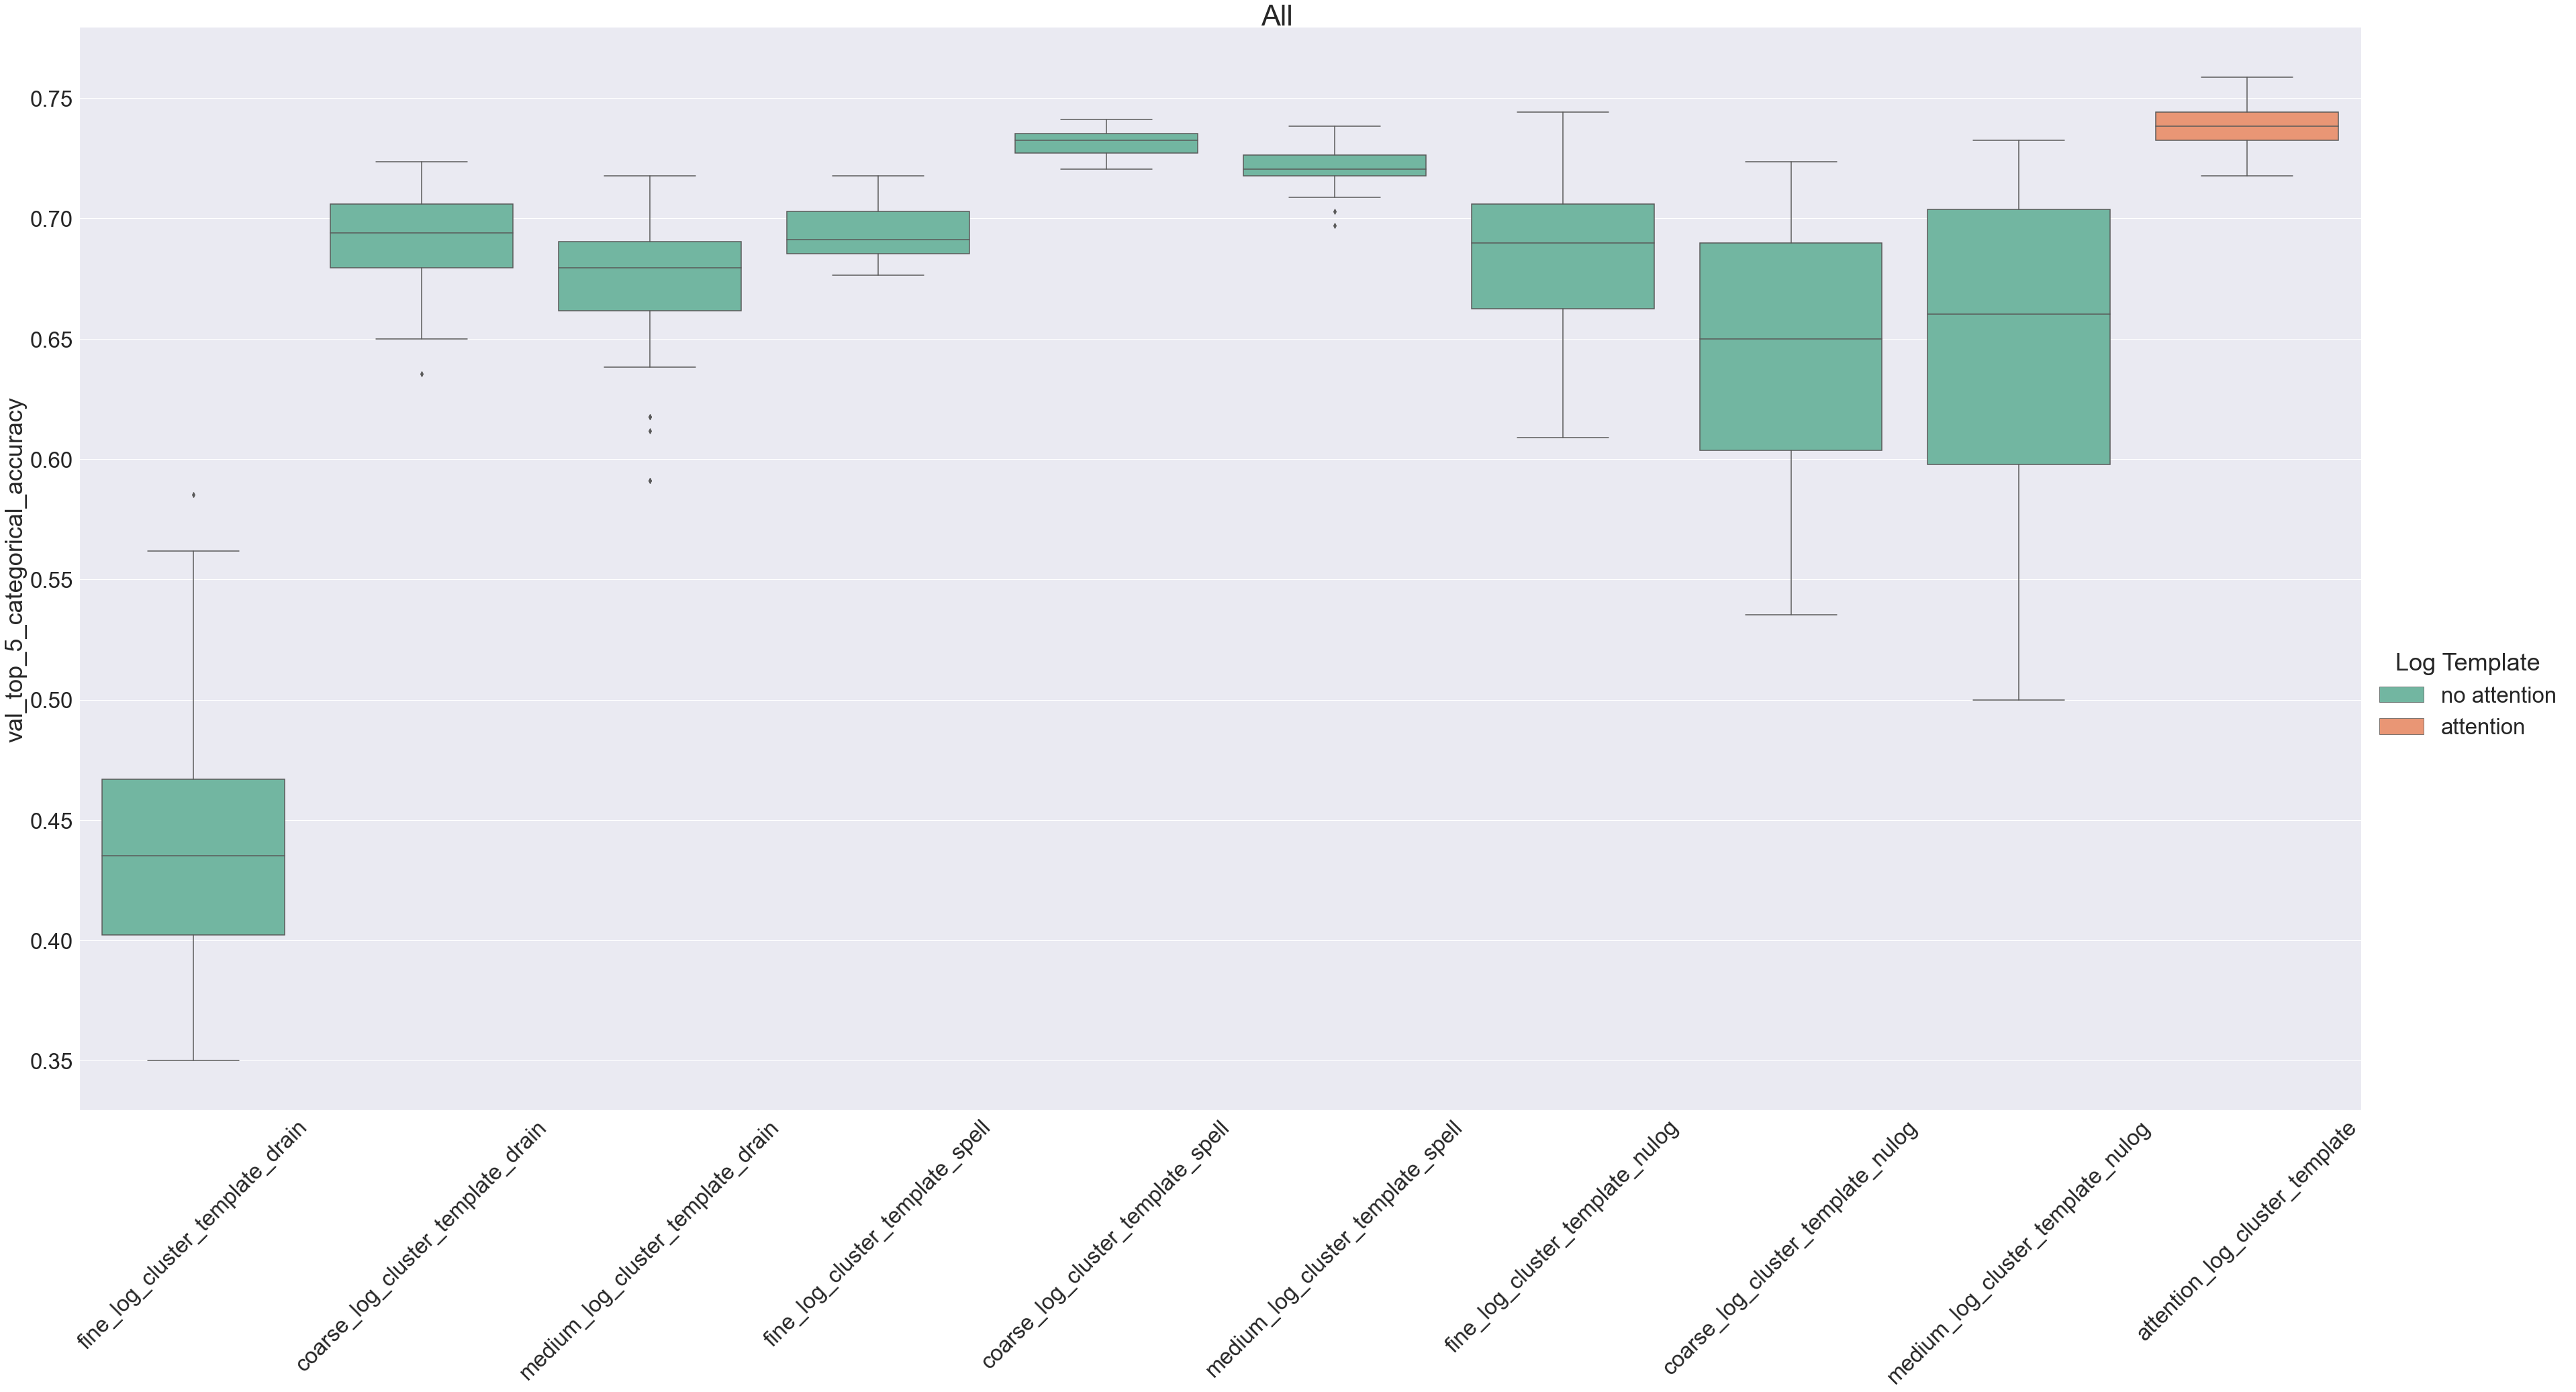

In [10]:
sns.set(font_scale=3)
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell",
           "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=25,
    aspect=2,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("all_results.png", dpi=120, bbox_inches="tight")
plt.suptitle("All")
plt.show()

In [12]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain",  "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell", "medium_log_cluster_template_spell"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,112
coarse_log_cluster_template_drain,attributes,simple,53
coarse_log_cluster_template_spell,attributes,simple,34
fine_log_cluster_template_drain,attributes,simple,56
fine_log_cluster_template_spell,attributes,simple,36
medium_log_cluster_template_drain,attributes,simple,54
medium_log_cluster_template_spell,attributes,simple,34


In [14]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 379/379 [00:22<00:00, 17.16it/s]


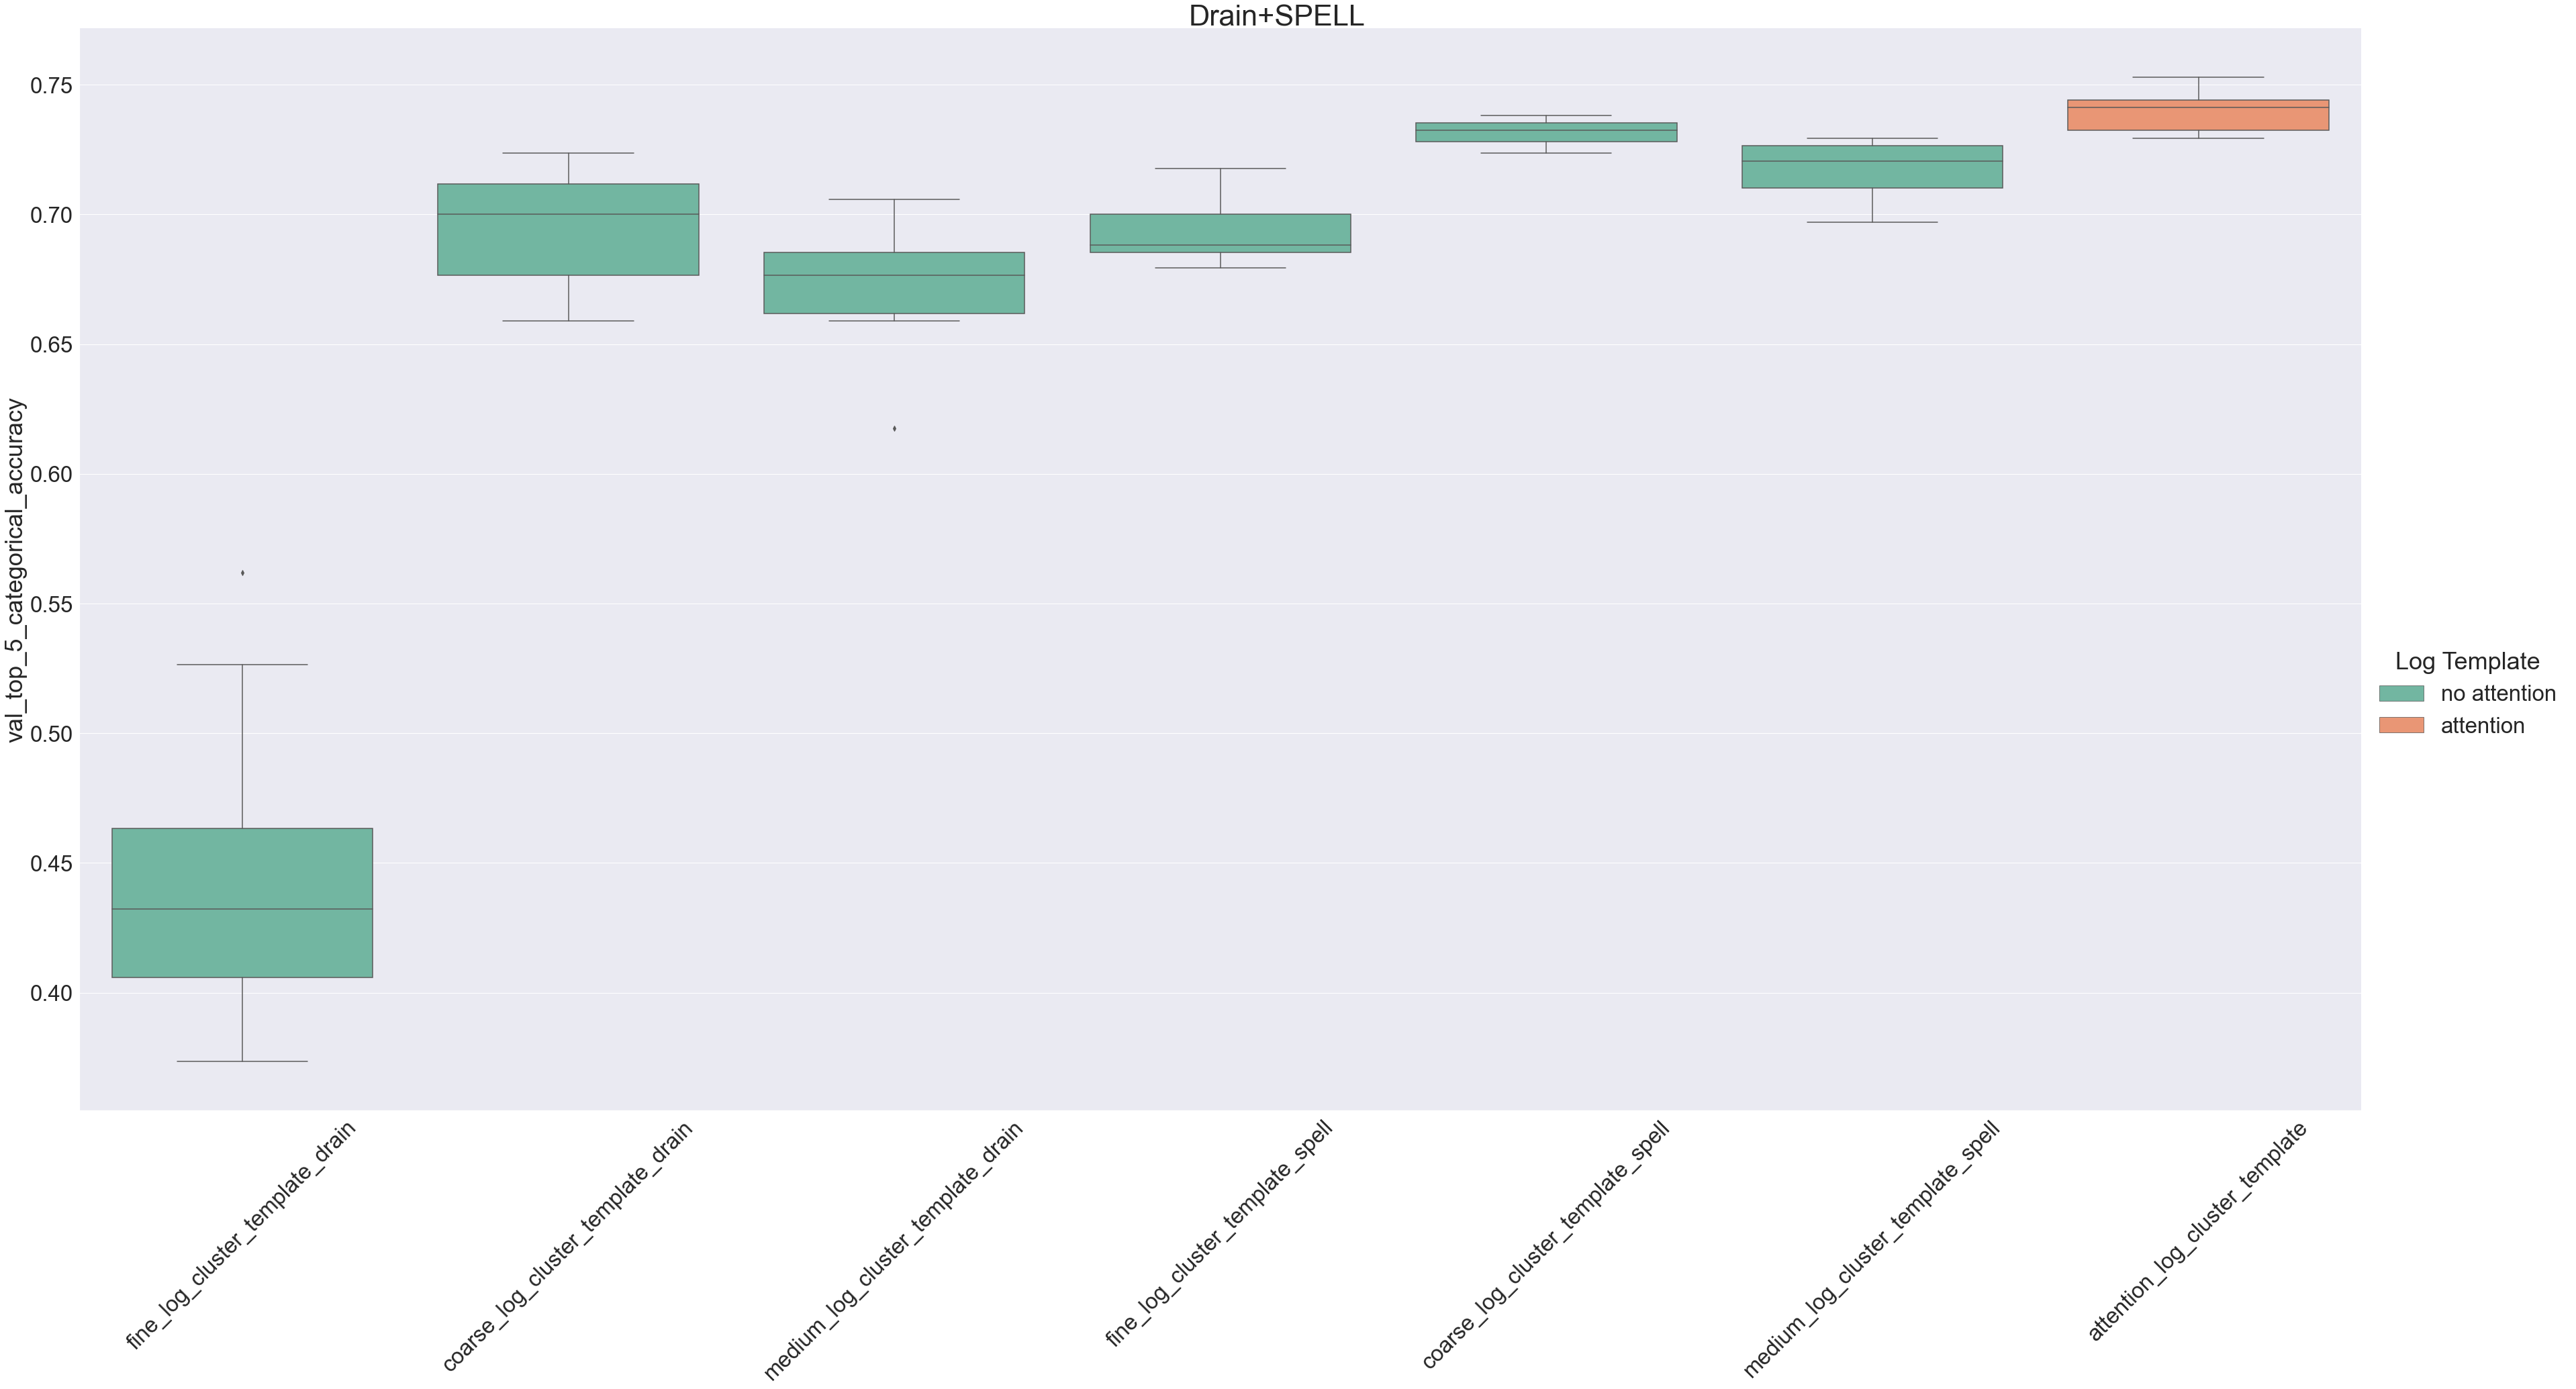

In [12]:
#sns.set(font_scale=4)
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "drain+spell")
        #& df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "nulog")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell", "medium_log_cluster_template_spell", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=25,
    aspect=2,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("drain+spell.png", dpi=120, bbox_inches="tight")
plt.suptitle("Drain+SPELL")
plt.show()

In [6]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain",  "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,112
coarse_log_cluster_template_drain,attributes,simple,53
coarse_log_cluster_template_nulog,attributes,simple,50
fine_log_cluster_template_drain,attributes,simple,56
fine_log_cluster_template_nulog,attributes,simple,50
medium_log_cluster_template_drain,attributes,simple,54
medium_log_cluster_template_nulog,attributes,simple,50


In [7]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 425/425 [00:25<00:00, 16.67it/s]


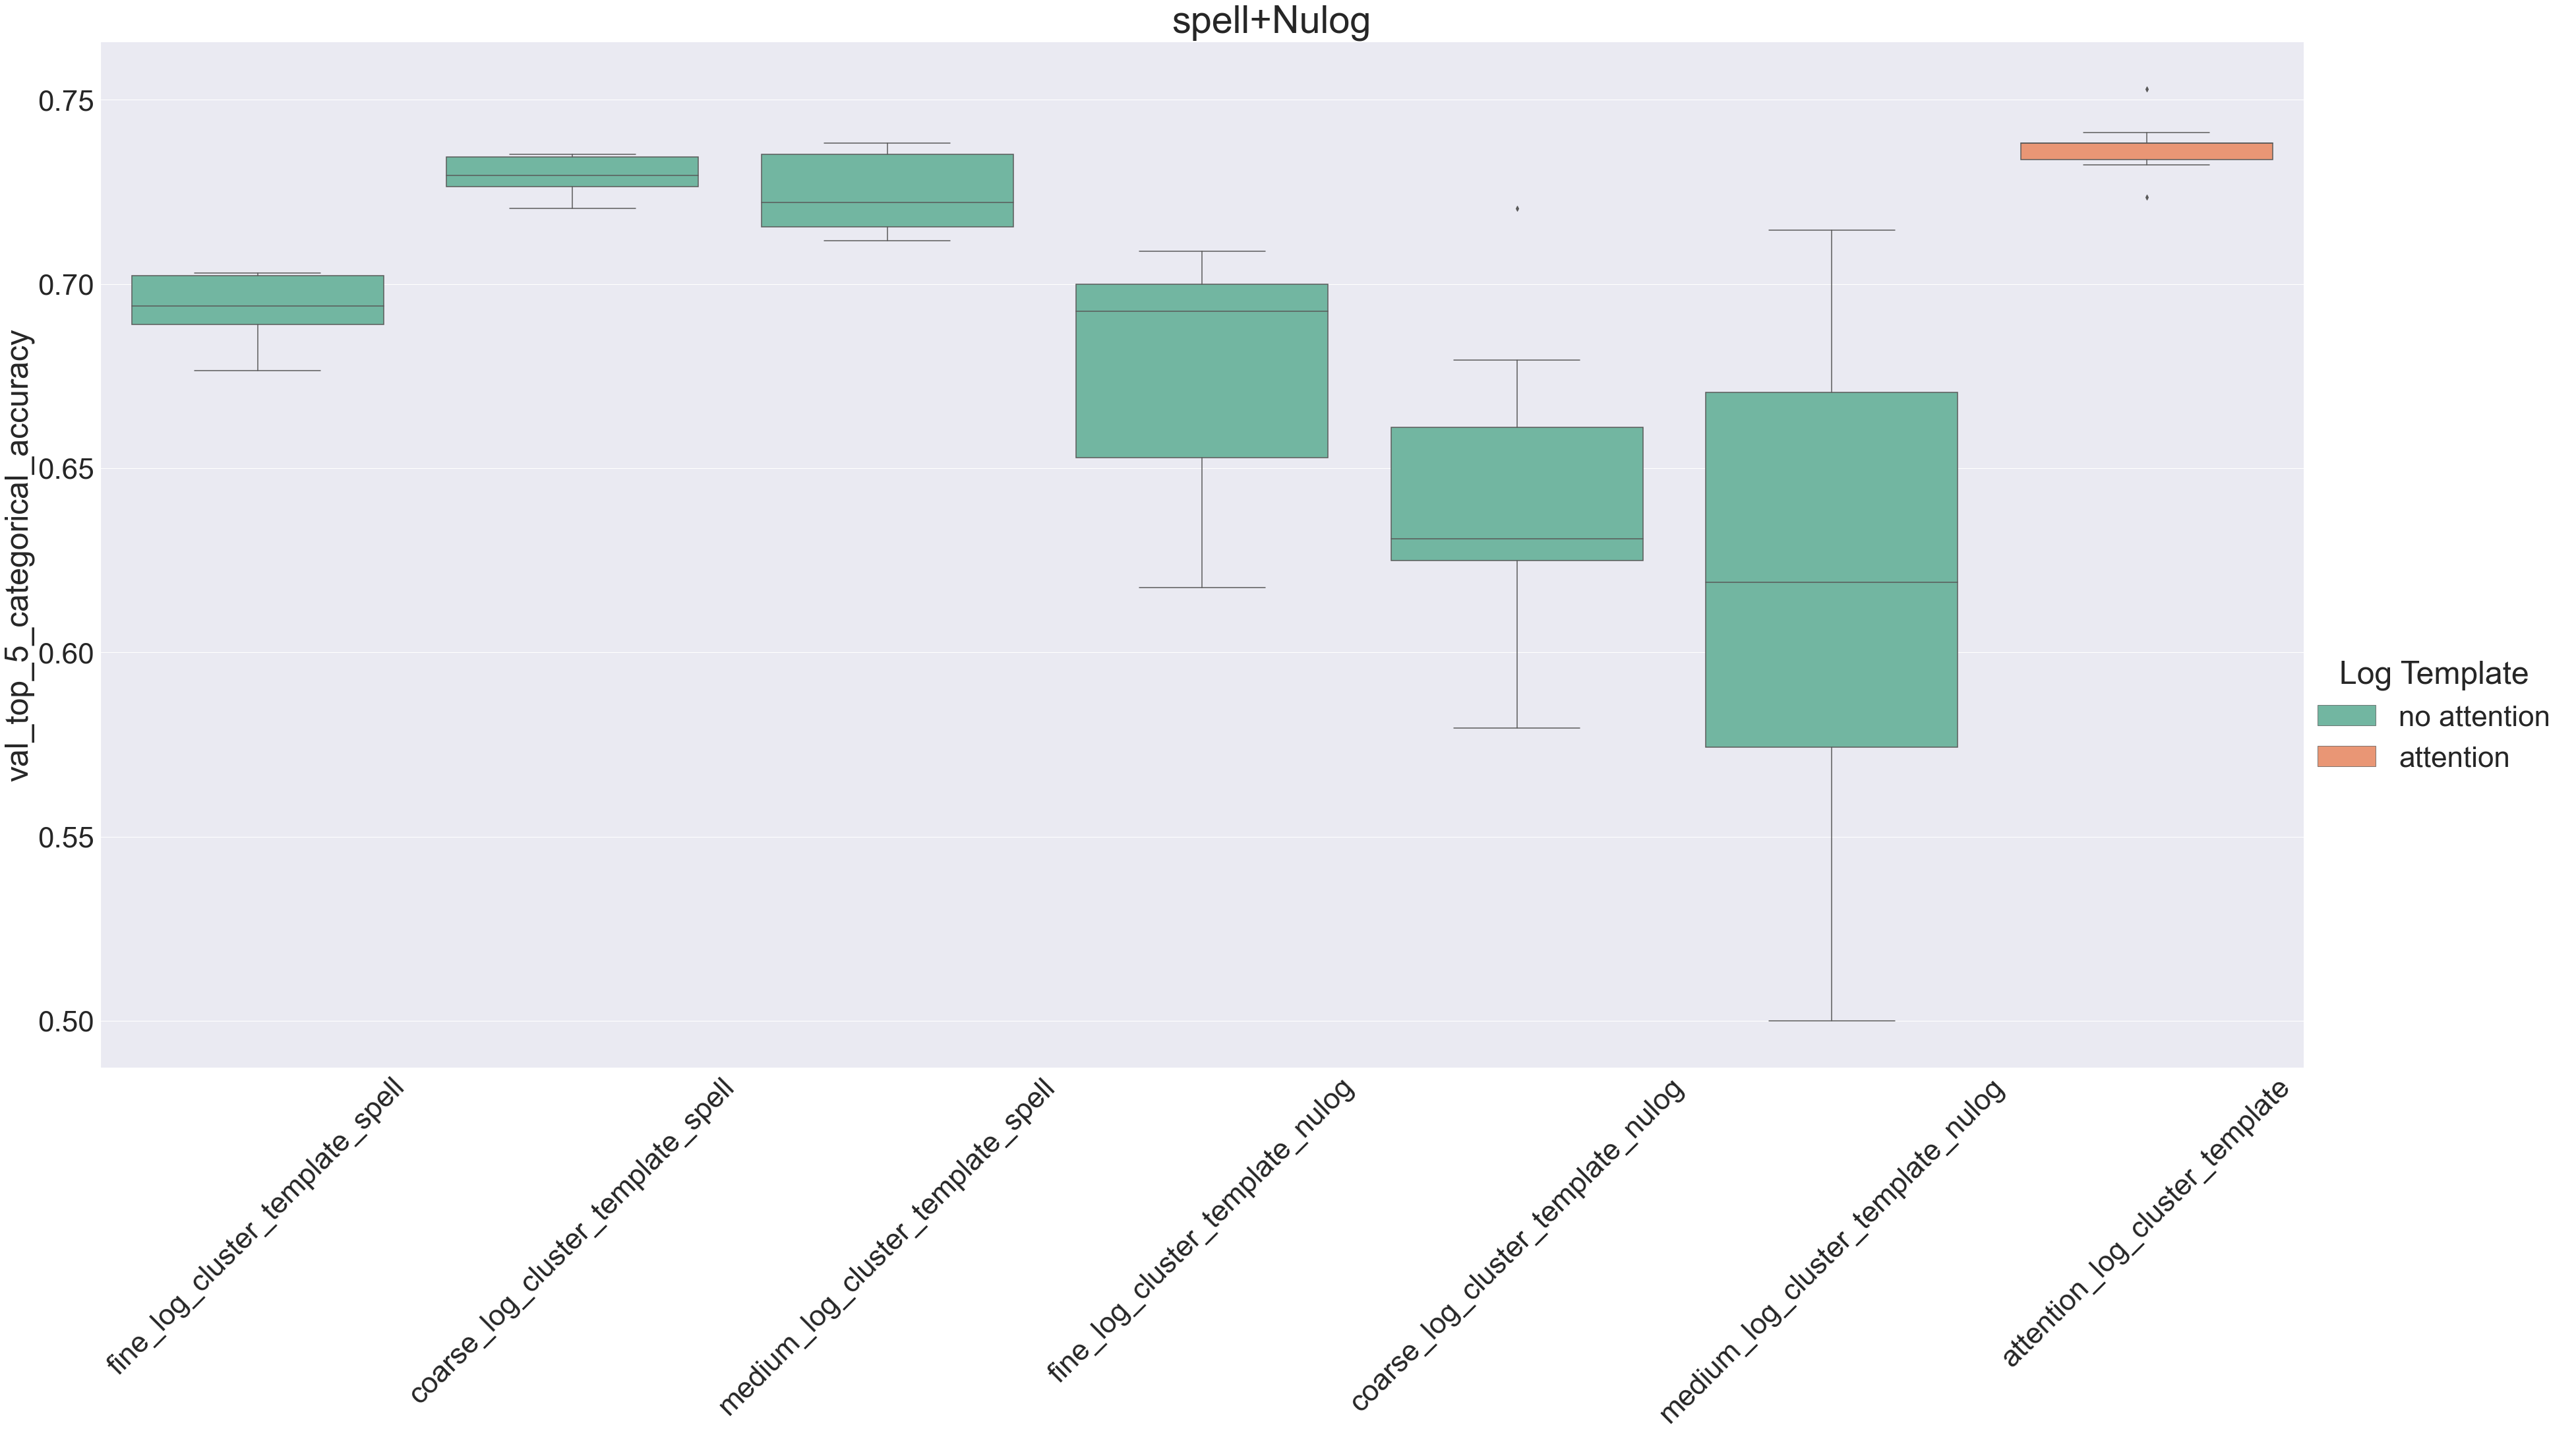

In [15]:
sns.set(font_scale=4)
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "spell+nulog")
        #& df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "nulog")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_spell", "coarse_log_cluster_template_spell", "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=25,
    aspect=2,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("spell+nulog.png", dpi=120, bbox_inches="tight")
plt.suptitle("spell+Nulog")
plt.show()

In [16]:
df = pd.read_pickle("../all_logs.pkl")
df["all_events"]

0    [[Hostname#wally113, coarse_log_cluster_templa...
Name: all_events, dtype: object

# Timestamp Comparison

In [58]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template", "", "medium_log_cluster_template"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=False,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,24
coarse_log_cluster_template,attributes,simple,24
fine_log_cluster_template,attributes,simple,24
medium_log_cluster_template,attributes,simple,24


In [59]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 96/96 [00:05<00:00, 16.34it/s]


In [34]:
huawei_metrics_df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"]

0      True
1     False
2     False
3      True
4     False
      ...  
89    False
90     True
91     True
92     True
93     True
Name: data_params_HuaweiPreprocessorConfigremove_dates_from_payload, Length: 94, dtype: object

0     Without Timestamps 200k
1          With Timestamps 5k
2          With Timestamps 5k
3       Without Timestamps 5k
4        With Timestamps 200k
               ...           
91         With Timestamps 5k
92    Without Timestamps 200k
93     Without Timestamps 20k
94    Without Timestamps 200k
95     Without Timestamps 20k
Name: Timestamps, Length: 96, dtype: object


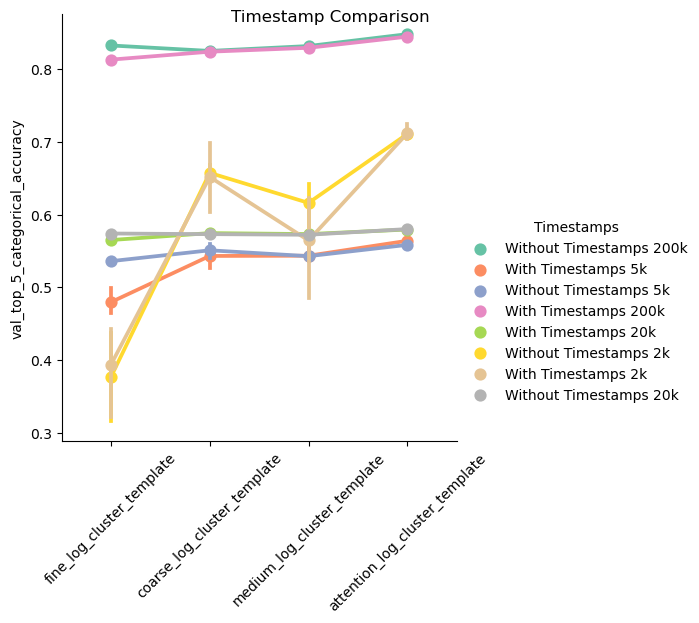

In [109]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))

# define conditions and choices
conditions = [
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'), 
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
]

choices = [
    'With Timestamps 2k',
    'With Timestamps 5k',
    'With Timestamps 20k',
    'With Timestamps 200k',
    'Without Timestamps 2k',
    'Without Timestamps 5k',
    'Without Timestamps 20k',
    'Without Timestamps 200k',
]

# create new column
df["Timestamps"] = np.select(conditions, choices, default="Unknown")
print(df["Timestamps"])


#df["Timestamps"] = df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: "With Timestamps" if x=="False" else "Without Timestamps")
g = sns.catplot(
    data=df,
    hue="Timestamps",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "medium_log_cluster_template", "attention_log_cluster_template"],
    kind="point",
    palette="Set2",
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("timestamps_comparison.png", dpi=120, bbox_inches="tight")
plt.suptitle("Timestamp Comparison")
plt.show()

In [76]:
dff = huawei_metrics_df.copy()
df

,val_loss_history_best,val_loss_times_best,val_top_5_categorical_accuracy_p2_history_best,val_top_5_categorical_accuracy_p2_times_best,val_categorical_accuracy_history_best,val_categorical_accuracy_times_best,top_20_categorical_accuracy_p2_history_best,top_20_categorical_accuracy_p2_times_best,top_5_categorical_accuracy_p4_history_best,top_5_categorical_accuracy_p4_times_best,...,info_artifact_uri,info_end_time,info_experiment_id,info_lifecycle_stage,info_run_name,info_run_uuid,info_start_time,info_status,info_user_id,Timestamps
0,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678150e+12,222398694951089913,active,gentle-stoat-188,6f8067a299784d1ea94aaa6dda2fa13c,1.678149e+12,FINISHED,pacev,Without Timestamps
1,0.117037,1678114257456,0.000000,1678114257460,0.191589,1678114257456,0.090323,1678114257455,0.746823,1678114257448,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678114e+12,222398694951089913,active,amusing-hen-425,d1fb70c6860a429088d8f354409a2dba,1.678114e+12,FINISHED,pacev,With Timestamps
2,0.114125,1678114082407,0.000000,1678114082411,0.202804,1678114082407,0.058065,1678114082406,0.745385,1678114082399,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678114e+12,222398694951089913,active,debonair-conch-826,45805c89e3de475d9a325bdb7f76bc9b,1.678114e+12,FINISHED,pacev,With Timestamps
3,0.117978,1678115565677,0.000000,1678115565682,0.170093,1678115565678,0.025806,1678115565676,0.733877,1678115565669,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678116e+12,222398694951089913,active,fortunate-crane-760,5d5f1bdca6474e6e9f3e28d028795ffc,1.678115e+12,FINISHED,pacev,Without Timestamps
4,0.051053,1678128875913,0.041096,1678128875918,0.223085,1678128875914,0.752279,1678128875912,0.789959,1678128875904,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678129e+12,222398694951089913,active,painted-lamb-688,7f01ebd42b544848be2e03e4085d76df,1.678128e+12,FINISHED,pacev,With Timestamps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.109427,1678115067677,0.000000,1678115067681,0.212150,1678115067677,0.612903,1678115067675,0.773675,1678115067669,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678115e+12,222398694951089913,active,bittersweet-pug-747,46961c3a654a49f8b39801e415e31d17,1.678115e+12,FINISHED,pacev,With Timestamps
92,0.050840,1678139366103,0.027397,1678139366108,0.223913,1678139366103,0.752279,1678139366101,0.795326,1678139366094,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678140e+12,222398694951089913,active,rare-fish-572,327199b0a34547eebcb34cdcf65b027c,1.678138e+12,FINISHED,pacev,Without Timestamps
93,0.082317,1678120327573,0.088235,1678120327578,0.215568,1678120327573,0.568345,1678120327572,0.616738,1678120327564,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678120e+12,222398694951089913,active,popular-dove-737,d37b0bd6ed3d4cd2bd7ecfc13ef0b33a,1.678120e+12,FINISHED,pacev,Without Timestamps
94,0.050643,1678143284949,0.041096,1678143284954,0.222928,1678143284949,0.758224,1678143284947,0.796481,1678143284940,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678144e+12,222398694951089913,active,agreeable-cub-545,384dc268a98d48a7868dfac190ee3c66,1.678142e+12,FINISHED,pacev,Without Timestamps


In [67]:
df2.merge(df2, left_on="data_params_HuaweiPreprocessorConfigremove_dates_from_payload", right_on="data_params_HuaweiPreprocessorConfigaggregated_log_file")

,val_loss_history_best_x,val_loss_times_best_x,val_top_5_categorical_accuracy_p2_history_best_x,val_top_5_categorical_accuracy_p2_times_best_x,val_categorical_accuracy_history_best_x,val_categorical_accuracy_times_best_x,top_20_categorical_accuracy_p2_history_best_x,top_20_categorical_accuracy_p2_times_best_x,top_5_categorical_accuracy_p4_history_best_x,top_5_categorical_accuracy_p4_times_best_x,...,data_tags_mlflow.source.git.commit_y,info_artifact_uri_y,info_end_time_y,info_experiment_id_y,info_lifecycle_stage_y,info_run_name_y,info_run_uuid_y,info_start_time_y,info_status_y,info_user_id_y


In [69]:
df2['merged_column'] = df2['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'].combine_first(df2['data_params_HuaweiPreprocessorConfigaggregated_log_file'])

In [70]:
df2['merged_column']

0      True
1     False
2     False
3      True
4     False
      ...  
91    False
92     True
93     True
94     True
95     True
Name: merged_column, Length: 96, dtype: object

In [72]:
df_merged = pd.merge(df, df, on=['data_params_HuaweiPreprocessorConfigremove_dates_from_payload', 'data_params_HuaweiPreprocessorConfigaggregated_log_file'], how='inner')

In [75]:
df_merged

,val_loss_history_best_x,val_loss_times_best_x,val_top_5_categorical_accuracy_p2_history_best_x,val_top_5_categorical_accuracy_p2_times_best_x,val_categorical_accuracy_history_best_x,val_categorical_accuracy_times_best_x,top_20_categorical_accuracy_p2_history_best_x,top_20_categorical_accuracy_p2_times_best_x,top_5_categorical_accuracy_p4_history_best_x,top_5_categorical_accuracy_p4_times_best_x,...,info_artifact_uri_y,info_end_time_y,info_experiment_id_y,info_lifecycle_stage_y,info_run_name_y,info_run_uuid_y,info_start_time_y,info_status_y,info_user_id_y,Timestamps_y
0,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678150e+12,222398694951089913,active,gentle-stoat-188,6f8067a299784d1ea94aaa6dda2fa13c,1.678149e+12,FINISHED,pacev,Without Timestamps
1,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678145e+12,222398694951089913,active,auspicious-lark-148,8aefce1855ca452baff1e24de935c0f4,1.678144e+12,FINISHED,pacev,Without Timestamps
2,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678182e+12,222398694951089913,active,dazzling-perch-149,0e1ac60dd367491fa806cf90dcfd61a4,1.678181e+12,FINISHED,pacev,Without Timestamps
3,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678141e+12,222398694951089913,active,intelligent-snail-47,36eba885bd5f48b9a88b308290a6df22,1.678140e+12,FINISHED,pacev,Without Timestamps
4,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678149e+12,222398694951089913,active,dapper-goat-924,32334a4ceed7479cbe67a27bc7f4457c,1.678148e+12,FINISHED,pacev,Without Timestamps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678121e+12,222398694951089913,active,bald-smelt-500,39e1abdb436a400a815ae1c3694746a3,1.678121e+12,FINISHED,pacev,Without Timestamps
1148,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678121e+12,222398694951089913,active,adaptable-boar-539,14f647c6cb42439ca4e2d94c30d93ec1,1.678121e+12,FINISHED,pacev,Without Timestamps
1149,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678119e+12,222398694951089913,active,trusting-bear-720,b11b8b56ccef48829d87bf96deb5e0e1,1.678119e+12,FINISHED,pacev,Without Timestamps
1150,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678120e+12,222398694951089913,active,popular-dove-737,d37b0bd6ed3d4cd2bd7ecfc13ef0b33a,1.678120e+12,FINISHED,pacev,Without Timestamps


In [88]:
conditions = [
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'), 
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
]

choices = [
    'With Timestamps 2k',
    'With Timestamps 5k',
    'With Timestamps 20k',
    'With Timestamps 200k'
    'Without Timestamps 2k',
    'Without Timestamps 5k',
    'Without Timestamps 20k',
    'Without Timestamps 200k',
]
len(choices)

7

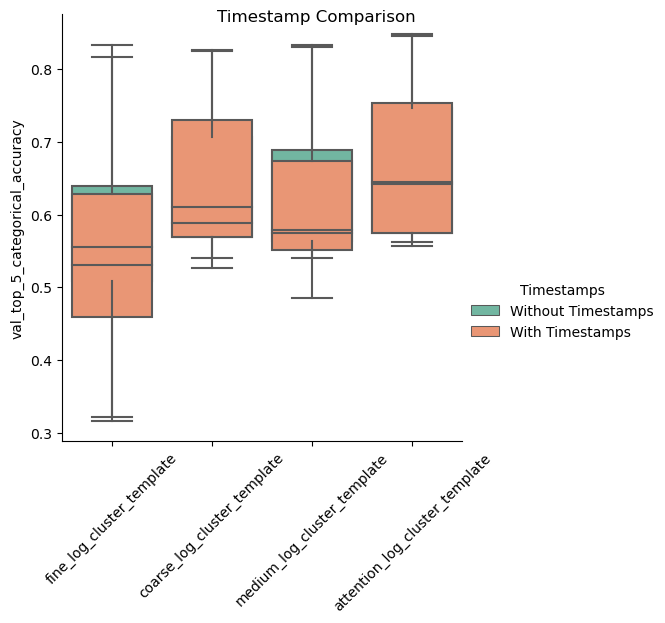

In [106]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Timestamps"] = df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: "With Timestamps" if x=="False" else "Without Timestamps")
g = sns.catplot(
    data=df,
    hue="Timestamps",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "medium_log_cluster_template", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("timestamps_comparison.png", dpi=120, bbox_inches="tight")
plt.suptitle("Timestamp Comparison")
plt.show()